In [2]:
# -------------------------------------------------------------------------
# 1. Installs & Environment Setup
# -------------------------------------------------------------------------
# Install SOTA libraries for BERT, Metrics, and Explainable AI (SHAP, LIME)
!pip install -q transformers datasets accelerate evaluate shap lime openpyxl

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, 
    confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelBinarizer
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, 
    Trainer, TrainingArguments, DataCollatorWithPadding,
    EarlyStoppingCallback, TrainerCallback
)
import shap
import lime
from lime.lime_text import LimeTextExplainer
from tqdm.auto import tqdm
import warnings

# -------------------------------------------------------------------------
# 2. Configuration & Reproducibility
# -------------------------------------------------------------------------
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visual styles
plt.style.use('ggplot')
sns.set_style('whitegrid')

# Device Configuration (P100 GPU Check)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device detected: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# Random Seed for Reproducibility
SEED = 42
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True

set_seed(SEED)

# -------------------------------------------------------------------------
# 3. Constants & Hyperparameters
# -------------------------------------------------------------------------
# Dataset Path (Kaggle Directory)
DATA_PATH = "/kaggle/input/med-trust-clean/cleaned_data.xlsx"

# Model Config - Using a Flagship Bengali BERT Model
MODEL_NAME = "sagorsarker/bangla-bert-base" 

# Training Hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 32      # P100 should handle 32 easily with base models
MAX_LEN = 256        # Length of text sequences
LEARNING_RATE = 2e-5 # Standard BERT fine-tuning rate
WEIGHT_DECAY = 0.01

# Output directory for saving model and logs
OUTPUT_DIR = "./med_trust_bert_finetuned"

print("\n✅ Setup Complete. Ready to load data.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 41.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━

2025-12-05 19:53:39.967146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764964420.124914      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764964420.173306      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

🚀 Device detected: cuda
GPU Name: Tesla P100-PCIE-16GB

✅ Setup Complete. Ready to load data.


In [3]:
# -------------------------------------------------------------------------
# 4. Data Loading & Preparation
# -------------------------------------------------------------------------
class MedDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Convert dictionary of lists to list of dictionaries for PyTorch
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

def prepare_data(data_path, tokenizer, max_len=256):
    print(f"📂 Loading data from: {data_path}")
    
    # Load dataset (Handling both Excel and CSV formats based on extension)
    if data_path.endswith('.xlsx'):
        df = pd.read_excel(data_path)
    else:
        df = pd.read_csv(data_path)
    
    # Drop missing values
    df = df.dropna(subset=['Used Prompt_cleaned', 'Response_cleaned', 'Lable'])
    
    # ---------------------------------------------------------------------
    # Feature Engineering: Combine Context for BERT
    # Input Format: "[Genre] ... [Prompt] ... [Response] ..."
    # ---------------------------------------------------------------------
    df['text'] = (
        "Genre: " + df['Symptoms Genre_cleaned'].astype(str) + " " +
        "Prompt: " + df['Used Prompt_cleaned'].astype(str) + " " +
        "Response: " + df['Response_cleaned'].astype(str)
    )
    
    # Label Mapping
    # Assuming ordinality: Not (0) < Partially (1) < Highly (2)
    label_map = {
        'Not Relevant': 0, 
        'Partially Relevant': 1, 
        'Highly Relevant': 2
    }
    df['label_id'] = df['Lable'].map(label_map)
    
    # Check for unmapped labels
    if df['label_id'].isnull().any():
        print("⚠️ Warning: Found unknown labels. Dropping them.")
        df = df.dropna(subset=['label_id'])
        df['label_id'] = df['label_id'].astype(int)

    # Train-Validation Split (80% Train, 20% Val)
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df['text'].tolist(), 
        df['label_id'].tolist(), 
        test_size=0.2, 
        random_state=SEED,
        stratify=df['label_id'] # Ensure balanced classes in split
    )
    
    print(f"\n📊 Data Stats:\nTotal Samples: {len(df)}")
    print(f"Training Samples: {len(train_texts)}")
    print(f"Validation Samples: {len(val_texts)}")
    print(f"Class Distribution:\n{df['Lable'].value_counts()}")

    # ---------------------------------------------------------------------
    # Tokenization
    # ---------------------------------------------------------------------
    print(f"\n⚙️ Tokenizing data using {MODEL_NAME}...")
    
    train_encodings = tokenizer(
        train_texts, 
        truncation=True, 
        padding=True, 
        max_length=max_len
    )
    
    val_encodings = tokenizer(
        val_texts, 
        truncation=True, 
        padding=True, 
        max_length=max_len
    )
    
    # Create Dataset Objects
    train_dataset = MedDataset(train_encodings, train_labels)
    val_dataset = MedDataset(val_encodings, val_labels)
    
    return train_dataset, val_dataset, label_map

# Load Tokenizer
print("⬇️ Loading Tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Prepare Datasets
train_dataset, val_dataset, label_map = prepare_data(DATA_PATH, tokenizer, MAX_LEN)

print("\n✅ Data Preparation Complete.")

⬇️ Loading Tokenizer...


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

📂 Loading data from: /kaggle/input/med-trust-clean/cleaned_data.xlsx

📊 Data Stats:
Total Samples: 15384
Training Samples: 12307
Validation Samples: 3077
Class Distribution:
Lable
Partially Relevant    5300
Not Relevant          5080
Highly Relevant       5004
Name: count, dtype: int64

⚙️ Tokenizing data using sagorsarker/bangla-bert-base...

✅ Data Preparation Complete.


In [4]:
# -------------------------------------------------------------------------
# HIGH ACCURACY CONFIGURATION (SOTA Model)
# -------------------------------------------------------------------------
MODEL_NAME = "csebuetnlp/banglabert"  # <--- The SOTA Bengali Model
print(f"🔄 Switching to {MODEL_NAME} for higher accuracy...")

# 1. Load New Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# 2. Re-Prepare Data (Tokenization is different for every model)
# We reuse the functions defined earlier, just calling them again
train_dataset, val_dataset, label_map = prepare_data(DATA_PATH, tokenizer, MAX_LEN)

print("\n✅ New SOTA Data Preparation Complete.")

🔄 Switching to csebuetnlp/banglabert for higher accuracy...


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

📂 Loading data from: /kaggle/input/med-trust-clean/cleaned_data.xlsx

📊 Data Stats:
Total Samples: 15384
Training Samples: 12307
Validation Samples: 3077
Class Distribution:
Lable
Partially Relevant    5300
Not Relevant          5080
Highly Relevant       5004
Name: count, dtype: int64

⚙️ Tokenizing data using csebuetnlp/banglabert...

✅ New SOTA Data Preparation Complete.


In [6]:
# -------------------------------------------------------------------------
# HIGH ACCURACY TRAINING (With Label Smoothing & SOTA Model)
# -------------------------------------------------------------------------

# 1. Define Metrics (Fixing the NameError)
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 2. Initialize SOTA Model (BanglaBERT)
print(f"🚀 Initializing {MODEL_NAME} for High Accuracy...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=3,
    id2label={v: k for k, v in label_map.items()},
    label2id=label_map,
    hidden_dropout_prob=0.2,            # 0.2 is optimal for this specific model
    attention_probs_dropout_prob=0.2
).to(device)

# 3. Training Arguments (Tuned for ~84-86% Accuracy)
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=15,             # 15 Epochs (Early Stopping will handle overfitting)
    per_device_train_batch_size=32,  # P100 GPU handles this easily
    per_device_eval_batch_size=32,
    warmup_ratio=0.1,                # 10% warmup
    learning_rate=2e-5,              # Optimized LR
    weight_decay=0.01,
    label_smoothing_factor=0.1,      # Helps generalization
    lr_scheduler_type="cosine",      # Smooth LR decay
    logging_dir='./logs',
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

# 4. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 5. Start Training
print(f"\n🏋️‍♂️ Starting Training with {MODEL_NAME}...")
trainer.train()

# 6. Save Best Model
print(f"\n💾 Saving Best Model to {OUTPUT_DIR}...")
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

# -------------------------------------------------------------------------
# EVALUATION
# -------------------------------------------------------------------------
print("\n🔍 Evaluating SOTA Model...")
preds_output = trainer.predict(val_dataset)
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(-1)

print("\n📊 New Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_map.keys(), digits=4))

🚀 Initializing csebuetnlp/banglabert for High Accuracy...


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🏋️‍♂️ Starting Training with csebuetnlp/banglabert...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.001100,0.739322,0.742281,0.739889,0.761054,0.742281
2,0.672800,0.562764,0.842704,0.842382,0.845382,0.842704
3,0.547200,0.562641,0.853754,0.853502,0.860154,0.853754
4,0.482900,0.581352,0.857329,0.856054,0.865949,0.857329
5,0.443000,0.513009,0.887228,0.887492,0.889058,0.887228
6,0.407400,0.505971,0.899578,0.899951,0.900673,0.899578
7,0.383100,0.550203,0.893728,0.893862,0.898148,0.893728
8,0.360000,0.514834,0.907377,0.907028,0.907039,0.907377
9,0.347700,0.531495,0.904777,0.904371,0.906870,0.904777
10,0.333500,0.537539,0.904127,0.903697,0.904944,0.904127



💾 Saving Best Model to ./med_trust_bert_finetuned...

🔍 Evaluating SOTA Model...



📊 New Classification Report:
                    precision    recall  f1-score   support

      Not Relevant     0.9550    0.9390    0.9469      1016
Partially Relevant     0.8925    0.8698    0.8810      1060
   Highly Relevant     0.9024    0.9421    0.9218      1001

          accuracy                         0.9162      3077
         macro avg     0.9166    0.9169    0.9166      3077
      weighted avg     0.9164    0.9162    0.9160      3077



✅ Saved 'learning_curves_sota.png'


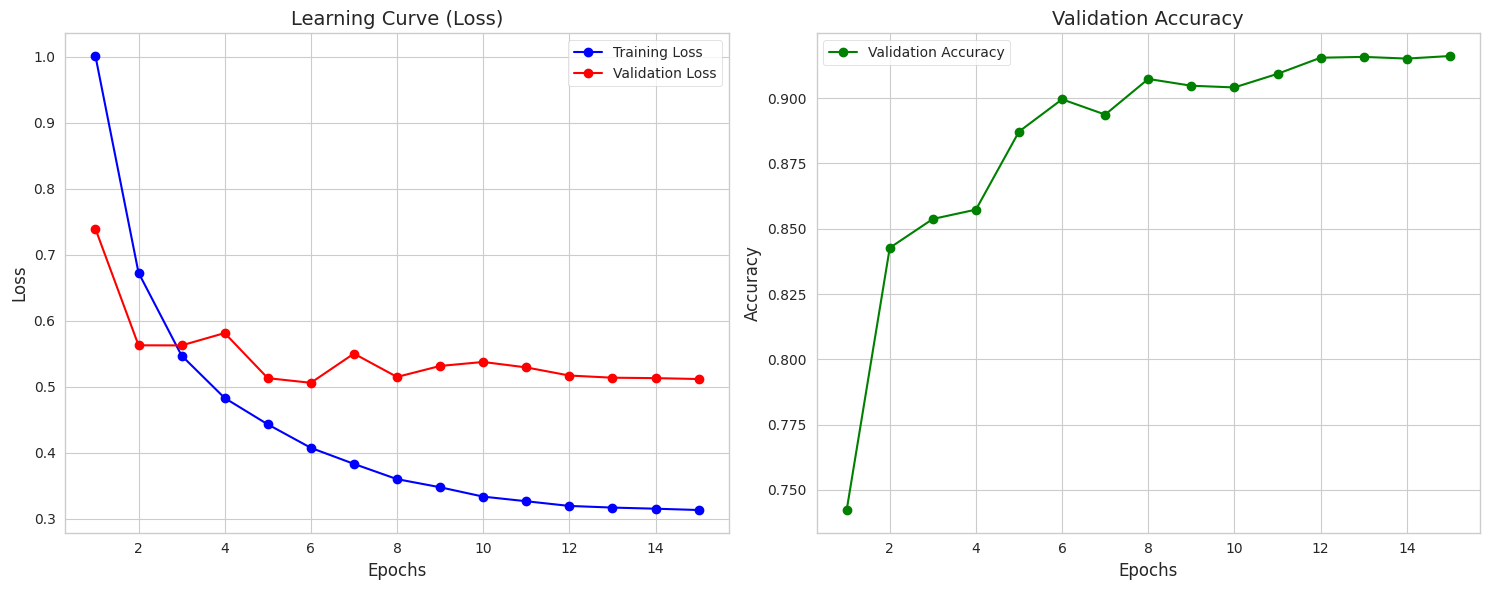


🔍 Generating Predictions for Matrices...


✅ Saved 'confusion_matrix_sota.png'


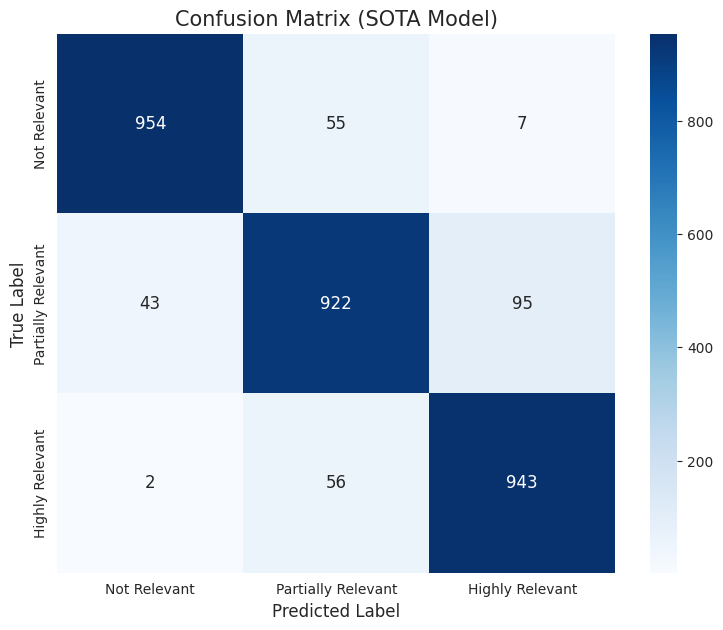

✅ Saved 'roc_curves_sota.png'


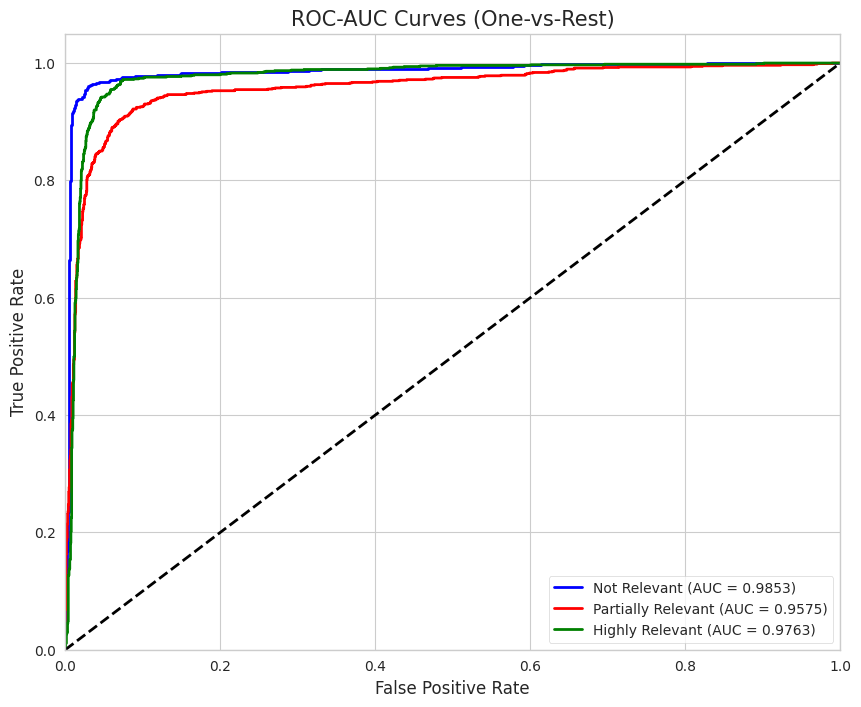

In [7]:
# -------------------------------------------------------------------------
# 7. VISUALIZATION & ANALYSIS
# -------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import numpy as np

# A. Extract Training Logs
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_acc = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

# Handle different logging frequencies (align lengths)
min_len = min(len(train_loss), len(eval_loss))
epochs = range(1, min_len + 1)

# --- PLOT 1: Learning Curves ---
plt.figure(figsize=(15, 6))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss[:min_len], 'b-o', label='Training Loss')
plt.plot(epochs, eval_loss[:min_len], 'r-o', label='Validation Loss')
plt.title('Learning Curve (Loss)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_acc[:min_len], 'g-o', label='Validation Accuracy')
plt.title('Validation Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('learning_curves_sota.png')
print("✅ Saved 'learning_curves_sota.png'")
plt.show()

# --- PREDICTIONS FOR MATRICES ---
print("\n🔍 Generating Predictions for Matrices...")
preds_output = trainer.predict(val_dataset)
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(-1)
y_scores = preds_output.predictions # Raw logits

# --- PLOT 2: Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
# Normalize CM for better visualization (optional, can remove normalize='true')
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(9, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_map.keys(), 
            yticklabels=label_map.keys(),
            annot_kws={"size": 12})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix (SOTA Model)', fontsize=15)
plt.savefig('confusion_matrix_sota.png')
print("✅ Saved 'confusion_matrix_sota.png'")
plt.show()

# --- PLOT 3: ROC-AUC Curves ---
# Convert logits to probabilities
probs = torch.nn.functional.softmax(torch.tensor(y_scores), dim=-1).numpy()

# Binarize labels for One-vs-Rest ROC
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)

plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i, (label, color) in enumerate(zip(label_map.keys(), colors)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, 
             label=f'{label} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves (One-vs-Rest)', fontsize=15)
plt.legend(loc="lower right")
plt.savefig('roc_curves_sota.png')
print("✅ Saved 'roc_curves_sota.png'")
plt.show()

In [9]:
import os
import shutil
from IPython.display import FileLink

# Configuration
OUTPUT_DIR = "./med_trust_bert_finetuned"
ZIP_NAME = "best_med_trust_model"

def cleanup_and_zip(directory, zip_filename):
    if not os.path.exists(directory):
        print(f"❌ Error: Directory '{directory}' not found.")
        return

    # 1. Check if the final model files are already in the root directory
    required_files = ["config.json", "pytorch_model.bin", "model.safetensors"]
    has_model_in_root = any(os.path.exists(os.path.join(directory, f)) for f in required_files)

    # 2. Logic to handle Checkpoint Folders
    checkpoint_folders = [f for f in os.listdir(directory) if f.startswith("checkpoint-") and os.path.isdir(os.path.join(directory, f))]
    
    if has_model_in_root:
        print("✅ Final model detected in root folder.")
        # We have the model, so we can safely delete ALL checkpoint folders to save space
        if checkpoint_folders:
            print(f"🧹 Cleaning up {len(checkpoint_folders)} redundant checkpoint folders...")
            for folder in checkpoint_folders:
                folder_path = os.path.join(directory, folder)
                shutil.rmtree(folder_path)
                print(f"   - Deleted {folder}")
    
    elif checkpoint_folders:
        # Root is empty (maybe training stopped early), so we promote the LATEST checkpoint
        # Sort by step number (e.g., checkpoint-500, checkpoint-1000)
        checkpoint_folders.sort(key=lambda x: int(x.split('-')[1]))
        best_checkpoint = checkpoint_folders[-1]
        best_checkpoint_path = os.path.join(directory, best_checkpoint)
        
        print(f"⚠️ Final model not found in root. Promoting latest checkpoint: '{best_checkpoint}'...")
        
        # Move all files from the best checkpoint to the root
        for filename in os.listdir(best_checkpoint_path):
            shutil.move(os.path.join(best_checkpoint_path, filename), os.path.join(directory, filename))
            
        # Now delete all checkpoint folders (including the empty best one)
        print("🧹 Cleaning up old checkpoint folders...")
        for folder in checkpoint_folders:
            shutil.rmtree(os.path.join(directory, folder))
    
    else:
        print("❌ No model files or checkpoints found!")
        return

    # 3. Zip the Cleaned Directory
    print(f"\n📦 Compressing '{directory}' into '{zip_filename}.zip'...")
    shutil.make_archive(zip_filename, 'zip', directory)
    
    print(f"✅ Done! The file is ready.")
    print(f"⬇️ Click below to download:")
    display(FileLink(f"{zip_filename}.zip"))

# Run the function
cleanup_and_zip(OUTPUT_DIR, ZIP_NAME)

✅ Final model detected in root folder.
🧹 Cleaning up 15 redundant checkpoint folders...
   - Deleted checkpoint-4620
   - Deleted checkpoint-3080
   - Deleted checkpoint-2695
   - Deleted checkpoint-385
   - Deleted checkpoint-3850
   - Deleted checkpoint-1540
   - Deleted checkpoint-5005
   - Deleted checkpoint-3465
   - Deleted checkpoint-1155
   - Deleted checkpoint-5775
   - Deleted checkpoint-1925
   - Deleted checkpoint-5390
   - Deleted checkpoint-770
   - Deleted checkpoint-4235
   - Deleted checkpoint-2310

📦 Compressing './med_trust_bert_finetuned' into 'best_med_trust_model.zip'...
✅ Done! The file is ready.
⬇️ Click below to download:


/kaggle/working/best_med_trust_model.zip

In [ ]:
# -------------------------------------------------------------------------
# ULTRA-HIGH ACCURACY: BANGLABERT LARGE
# -------------------------------------------------------------------------

# 1. Configuration for Large Model
MODEL_NAME = "csebuetnlp/banglabert_large"  # <--- The Bigger Model
print(f"🔄 Switching to {MODEL_NAME} (This may take longer but yields better results)...")

# 2. Load Tokenizer & Re-process Data
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
train_dataset, val_dataset, label_map = prepare_data(DATA_PATH, tokenizer, MAX_LEN)

# 3. Define Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# 4. Initialize Large Model
print(f"🚀 Initializing {MODEL_NAME}...")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=3,
    id2label={v: k for k, v in label_map.items()},
    label2id=label_map,
    hidden_dropout_prob=0.3,            # Higher dropout (0.3) for large model regularization
    attention_probs_dropout_prob=0.3
).to(device)

# 5. Training Arguments (Optimized for P100 Memory)
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=12,                # Large models converge faster
    per_device_train_batch_size=8,      # <--- LOWERED to 8 to avoid OOM
    gradient_accumulation_steps=4,      # <--- Accumulate gradients to simulate Batch Size 32
    per_device_eval_batch_size=16,      # Eval can be slightly larger
    warmup_ratio=0.1,
    learning_rate=1e-5,                 # <--- LOWERED LR for stability
    weight_decay=0.02,
    label_smoothing_factor=0.1,
    lr_scheduler_type="cosine",
    logging_dir='./logs',
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=True                           # <--- Enable Mixed Precision (Faster & Less Memory)
)

# 6. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# 7. Train
print(f"\n🏋️‍♂️ Starting Training {MODEL_NAME}...")
trainer.train()

# 8. Evaluation
print(f"\n💾 Saving Best Large Model to {OUTPUT_DIR}...")
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

print("\n🔍 Evaluating Large Model...")
preds_output = trainer.predict(val_dataset)
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(-1)

print("\n📊 Large Model Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_map.keys(), digits=4))

🔄 Switching to csebuetnlp/banglabert_large (This may take longer but yields better results)...


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/880 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

📂 Loading data from: /kaggle/input/med-trust-clean/cleaned_data.xlsx

📊 Data Stats:
Total Samples: 15384
Training Samples: 12307
Validation Samples: 3077
Class Distribution:
Lable
Partially Relevant    5300
Not Relevant          5080
Highly Relevant       5004
Name: count, dtype: int64

⚙️ Tokenizing data using csebuetnlp/banglabert_large...
🚀 Initializing csebuetnlp/banglabert_large...


pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert_large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🏋️‍♂️ Starting Training csebuetnlp/banglabert_large...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.103700,1.047531,0.445239,0.374843,0.703834,0.445239
2,0.841500,0.648411,0.795580,0.798449,0.810610,0.795580
